In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches

%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.2f


'%.2f'

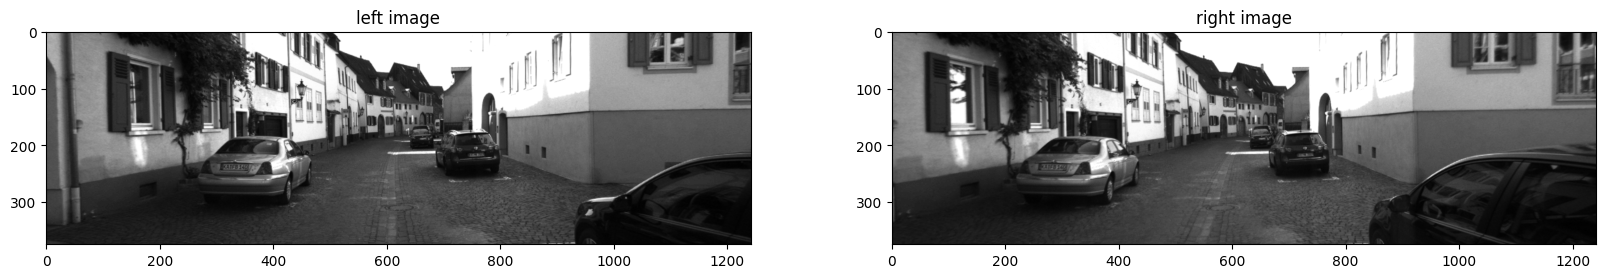

In [3]:
img_left = cv2.imread("left_img.png", cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread("right_img.png", cv2.IMREAD_GRAYSCALE)

_, image_cells = plt.subplots(1, 2, figsize=(20, 20))
image_cells[0].imshow(img_left, 'gray')
image_cells[0].set_title('left image')
image_cells[1].imshow(img_right, 'gray')
image_cells[1].set_title('right image')
plt.show()

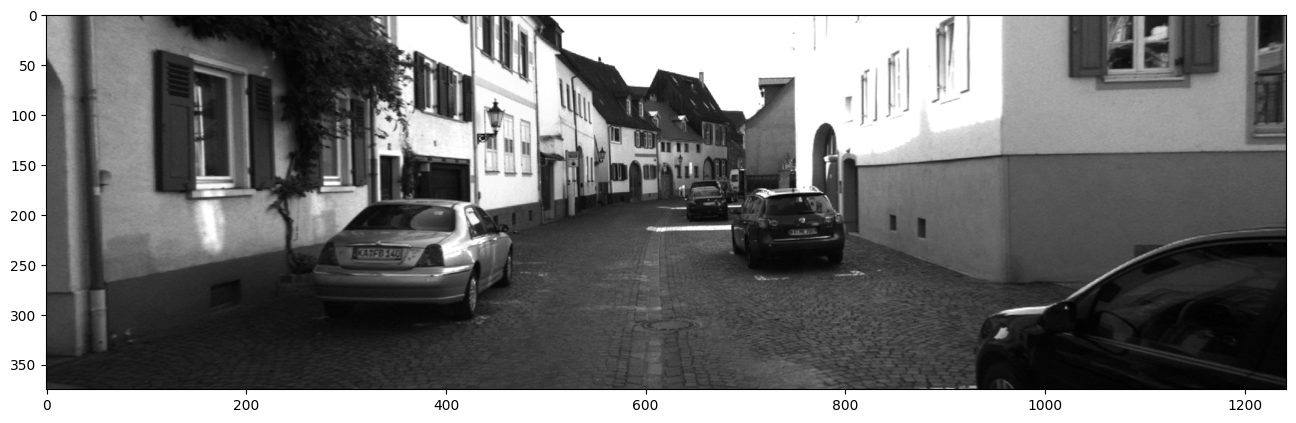

In [4]:
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(img_left, 'gray')

In [191]:
#arbitrary projection matrix
p_left = np.array([[480.0,   0.0, 640.0, 2176.0],
                   [  0.0, 480.0, 480.0,  552.0],
                   [  0.0,   0.0,   1.0,    1.4]])
p_right = np.array([[480.0,   0.0, 640.0, 2176.0],
                    [   0.0, 480.0, 480.0,  792.0],
                    [   0.0,   0.0,   1.0,    1.4]])

np.set_printoptions(suppress=True)

In [117]:
def compute_left_disparity_map(img_left, img_right):

    numDisparities = 80    # has to be dividable by 16
    blockSize      = 15     # (0, 25]
    windowSize     = 6     # Usually set equals to the block size

    left_matcher = cv2.StereoSGBM_create(
        minDisparity = 0,
        numDisparities = numDisparities,
        blockSize = blockSize,
        P1 = 8 * 3 * windowSize ** 2,
        P2 = 32 * 3 * windowSize ** 2,
        mode = 0
    )

    displ = left_matcher.compute(img_left, img_right)/16

    return displ

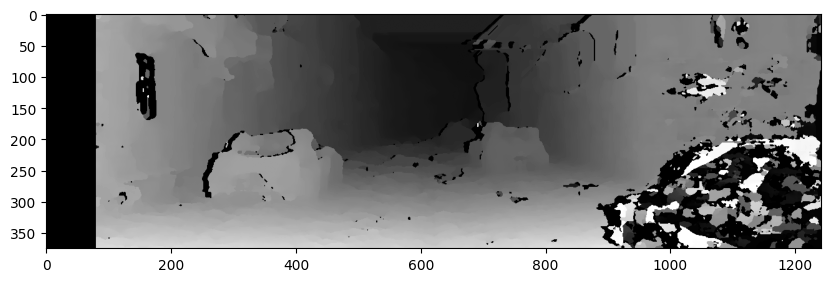

In [215]:
disp_left = compute_left_disparity_map(img_left, img_right)
disp_left = cv2.normalize(disp_left,None, 0, 255, cv2.NORM_MINMAX)

plt.figure(figsize=(10, 10))
plt.imshow(disp_left, 'gray')
plt.show()

In [203]:
def decompose_projection_matrix(p):

    m = p[:3,:3]
    #m_inv = np.linalg.inv(m)
    q, r = np.linalg.qr(m, mode='complete')

    k = r
    R = q

    t = -np.matmul(np.linalg.inv(k), p[:,3])

    return k, r, t

In [204]:
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

print("k_left \n", k_left)
print("\nr_left \n", r_left)
print("\nt_left \n", t_left)
print("\nk_right \n", k_right)
print("\nr_right \n", r_right)
print("\nt_right \n", t_right)

k_left 
 [[480.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_left 
 [[480.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

t_left 
 [-2.66666667  0.25       -1.4       ]

k_right 
 [[480.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_right 
 [[480.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

t_right 
 [-2.66666667 -0.25       -1.4       ]


In [236]:
def calc_depth_map(disp_left, k_left, t_left, t_right):

    f = k_left[0, 0]

    # baseline
    b = t_left[1] - t_right[1]

    max = np.max(disp_left)


    # depth map initialization
    depth_map = np.ones(disp_left.shape, np.float32)

    depth_map = f * b / disp_left
    depth_map[depth_map == np.max(depth_map)] = np.mean(depth_map)
    return depth_map

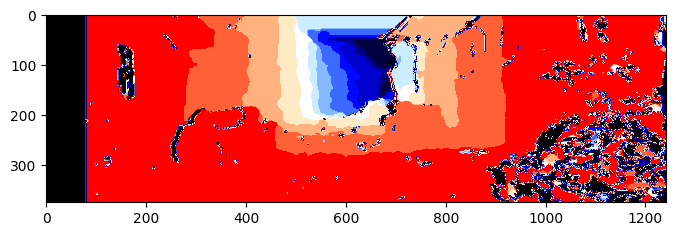

In [237]:
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)
depth_map_left = cv2.normalize(depth_map_left,None, 0, 255, cv2.NORM_MINMAX)

plt.figure(figsize=(8, 8))
plt.imshow(depth_map_left, 'flag')
plt.show()